In [1]:
import scipy.io as sp_io
import scipy.integrate as sp_int
import importlib
import torus
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import pandas as pd
import constants as const

 ChiantiPy version 0.15.0 
 found PyQt5 widgets
 using PyQt5 widgets


In [2]:
#constants 
c = 2.9979e10
mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8

In [3]:
#get star spectra from fits 

def get_spectra(fits_file):
    spec = fits.getdata(fits_file,1)
    wav = spec['WAVELENGTH'] * 1e-8       #in angstroms so turn into cgs 
    irr_wav = spec['FLUX'] * 1e8          
    nu = c / wav
    irr_nu = irr_wav * wav**2 / c
    return {'wl' : wav, 'F_wl': irr_wav, 'nu' : nu, 'F_nu' : irr_nu}

K6 = get_spectra('hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits')
K2 = get_spectra('hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_adapt-const-res-sed.fits')
G5 = get_spectra('hlsp_muscles_multi_multi_wasp-127_broadband_v24_adapt-const-res-sed.fits')
F4 = get_spectra('hlsp_muscles_multi_multi_wasp-43_broadband_v24_adapt-const-res-sed.fits')

def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = deepcopy(stellar_spectrum)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] < euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

normF4 = normalize_spectrum(F4, 10**4)

ss_idl = sp_io.readsav('ssi3_ext_0nm_1600nm.sav')
ss_wav = ss_idl['ssi3_ext'][0][0] #nm
ss_irr = ss_idl['ssi3_ext'][0][3][:, 1000] #mw/m^2/nm
ss_mod = ss_idl['ssi3_ext'][0][5][:, 1000] #mw/m^2/nm

#turn into cgs
ss_wav_cgs = ss_wav * 1e-7
ss_irr_cgs = ss_irr * 1e7
ss_nu_cgs = c / ss_wav_cgs
ss_irr_nu_cgs = ss_irr_cgs * ss_wav_cgs**2 / c

ss = {'wl' : ss_wav_cgs, 'F_wl' : ss_irr_cgs, 'nu' : ss_nu_cgs, 'F_nu' : ss_irr_nu_cgs}

norm_ss = normalize_spectrum(ss, 10**4)

In [4]:
#solar element ratio

solar_abundance = pd.read_excel('../SolarSystemAbundances_Lodders2021.xlsx', usecols = [1, 11], names = ['Element', 'Abundance'], skiprows=3, dtype={'Element':'string'}) #in astronomical abundance

#change to abundance relative to hydrogen
solar_abundance['Abundance'] = 10**(solar_abundance['Abundance'] - 12)
sa = dict(zip(solar_abundance['Element'], solar_abundance['Abundance']))
sola =  {k.lower(): v for k, v in sa.items()}

#change metallicity


In [5]:
#WASP12 parameters

WASP12b = {'mass_s':1.434*const.m_sun, 'radius_s':1.66*const.r_sun, 
           'mass_p':1.46*const.m_jupiter, 'radius_p':1.884*const.r_jupiter, 'semimajoraxis':0.02399*1.5e13, 'inclination': 1.485}

a_div_Rs = WASP12b['semimajoraxis'] / WASP12b['radius_s']

In [6]:
WASP12b_species_keys=['h', 'he', 'c', 'mg', 'ca']
WASP12b_species = dict((k, sola[k]) for k in WASP12b_species_keys)
          
WASP12bET = torus.Torus(species = WASP12b_species, stellar_spectrum = normF4, Ms = WASP12b['mass_s'], Rs = WASP12b['radius_s'], ap = WASP12b['semimajoraxis'], T = np.float64(10**4), Rtorus=[0.05*1.5e13, 0.06*1.5e13], i = np.pi/2, tau=1)
WASP12bET.calculate_ion_abundances_all_species()

In [7]:
WASP12 = torus.Torus({'h': 1, 'he' : 0.09, 'o' : 1e-3, 'mg' : 3e-5, 'ca': 1.5e-6}, norm_ss, 2.65e33, 1.66*7e10, 0.024*1.5e13, 1.0*10**4, [0.05*1.5e13, 0.06*1.5e13], np.pi/2, tau = 1)
WASP12.species_ion_abundances



{'h': array([0.03797711, 0.96202289]),
 'he': array([3.33255603e-02, 4.92034441e-06, 6.56771156e-01, 3.09898363e-01]),
 'o': array([1.11276428e-03, 1.17719897e-01, 6.89676800e-01, 1.90748101e-01,
        7.40042924e-04, 2.39188930e-06, 2.80497932e-09, 5.65737243e-14,
        4.47566796e-23]),
 'mg': array([1.31467615e-01, 4.70945447e-01, 3.31474656e-01, 6.44133973e-02,
        1.68710398e-03, 1.17710204e-05, 9.49897002e-09, 1.22700205e-12,
        8.38997574e-17, 2.03990041e-21, 1.07923078e-26, 1.91999449e-35,
        2.69386828e-44]),
 'ca': array([ 3.96479740e-04,  2.04830016e-01,  5.07083894e-01,  2.72760234e-01,
         1.49050876e-02,  2.42846849e-05,  4.64806449e-09,  1.08300863e-12,
         6.99509809e-17,  9.02059803e-21,  3.35878533e-25,  5.45917809e-30,
         1.79703388e-35,  9.85967458e-41,  2.89106819e-46,  7.79435142e-56,
         1.03618229e-65,  1.06459855e-75,  1.33456214e-85, -0.00000000e+00,
        -0.00000000e+00])}

In [8]:
len(WASP12.species_ion_abundances)

5

In [8]:
WASP12.mu

0.6099877689268943

In [10]:
tau_mg_lc = WASP12.calculate_tau_species('mg_2')
print(tau_mg_lc)

(array([5.98049133e+01, 2.98851470e+01, 5.95397441e-01, 5.58735504e-01,
       5.34600438e-01, 5.76236271e-01, 2.81529762e-01, 1.36549226e-01,
       7.35222057e-02, 4.87136145e-02]), array([2.796350e-05, 2.803531e-05, 1.995180e-06, 1.995080e-06,
       1.998070e-06, 2.483900e-06, 2.472100e-06, 2.090930e-06,
       2.094290e-06, 1.885300e-06]))


In [9]:
i_mg2, tau_mg2 = WASP12.do_transit('mg_2', ['mg2_h', 'mg2_k'], np.linspace(2.7958e-5, 2.7970e-5, 50))

50
6428571428.571411
393.6752398590086


In [10]:
"""%%prun
i_mg, tau_mg = WASP12bET.do_transit('mg_2', ['mg2_h', 'mg2_k'], np.linspace(2.7958e-5, 2.7970e-5, 300))
i_ca, tau_ca = WASP12bET.do_transit('ca_2', ['ca2_h', 'ca2_k'], np.linspace(3.9340e-5, 3.9355e-5, 300))
i_c, tau_c = WASP12bET.do_transit('c_2', ['c2_1335'], np.linspace(1.334e-05, 1.335e-5, 300))"""

"%%prun\ni_mg, tau_mg = WASP12bET.do_transit('mg_2', ['mg2_h', 'mg2_k'], np.linspace(2.7958e-5, 2.7970e-5, 300))\ni_ca, tau_ca = WASP12bET.do_transit('ca_2', ['ca2_h', 'ca2_k'], np.linspace(3.9340e-5, 3.9355e-5, 300))\ni_c, tau_c = WASP12bET.do_transit('c_2', ['c2_1335'], np.linspace(1.334e-05, 1.335e-5, 300))"

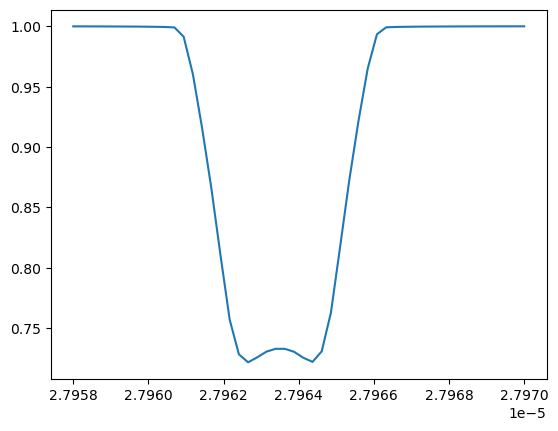

In [10]:
plt.plot(np.linspace(2.7958e-5, 2.7970e-5, 50), i_mg2)
plt.show()

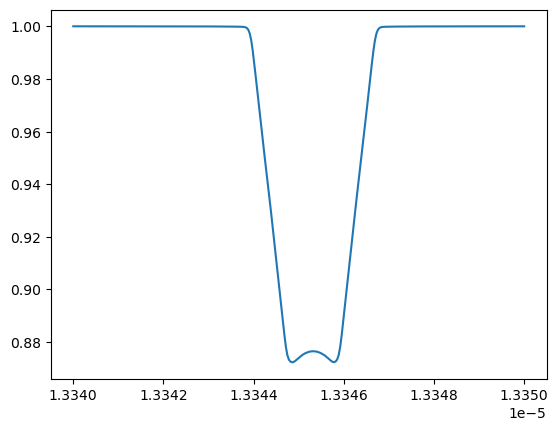

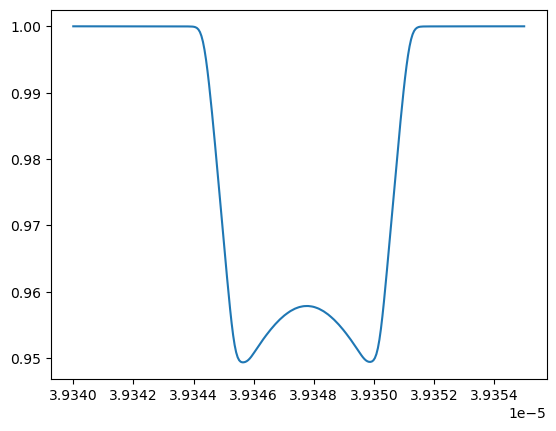

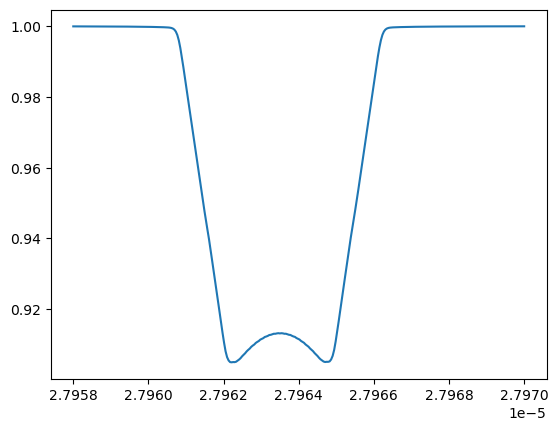

In [8]:
plt.plot(np.linspace(1.334e-05, 1.335e-5, 300), i_c)
plt.show()
plt.plot(np.linspace(3.9340e-5, 3.9355e-5, 300), i_ca)
plt.show()
plt.plot(np.linspace(2.7958e-5, 2.7970e-5, 300), i_mg)
plt.show()

In [9]:
#make a plot of how planet transit changes as a function of disk density  

In [ ]:
#make p-winds transit 



In [10]:
#make a plot of carbon line vs helium equivalent width

